# Machine Learning on Parking Space Occupancy in Dresden

Can we predict the occupation of a parking space ([Centrum-Galerie](https://www.bing.com/maps/default.aspx?q=centrum+galerie+dresden&mkt=de&FORM=HDRSC4)) in Dresden?

Read about it here: http://mechlab-engineering.de/2015/03/vorhersage-der-parkhausbelegung-mit-offenen-daten/

In [1]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as dates

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

pd.options.mode.chained_assignment = None  # default='warn'

Take the historical data from https://parkendd.de/dumps/

### Read the data and process it

In [2]:
name = 'Centrum Galerie'

In [3]:
url_2016 = 'https://parkendd.de/dumps/dresdencentrumgalerie-2016.csv'
url_2017 = 'https://parkendd.de/dumps/dresdencentrumgalerie-2017.csv'
url_2018 = 'https://parkendd.de/dumps/dresdencentrumgalerie-2018.csv'

In [4]:
data_2016 = pd.read_csv(url_2016, names=['Datum','free'], index_col='Datum', parse_dates=True)
data_2017 = pd.read_csv(url_2017, names=['Datum','free'], index_col='Datum', parse_dates=True)
data_2018 = pd.read_csv(url_2018, names=['Datum','free'], index_col='Datum', parse_dates=True)

data = pd.concat([data_2016, data_2017, data_2018])
data.sort_index(inplace=True)

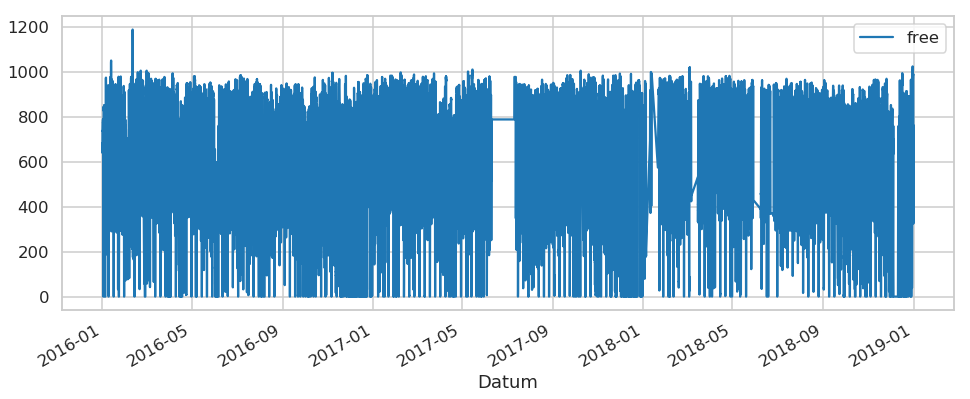

In [5]:
data.plot(figsize=(16,6));

In [6]:
data.dropna(inplace=True)

Calc the occupation ([ger] Belegung)

In [7]:
data['Belegung'] = 100.0-(data.free/950.0*100.0)
data['Belegung'] = data['Belegung'].astype(int)
data.drop('free', axis=1, inplace=True)

# Predict for the `parkingspot`

Ok, take a look at the TimeSeries

In [8]:
# function to plot timeseries with weekend
def plotbelegung(df, which, fromdate, todate):
    if fromdate=='':
        fromdate=df.index[0]
    if todate=='':
        todate=df.index[-1]

    weekend = df[fromdate:todate].index[df[fromdate:todate].index.weekday>4]
    ax = df[fromdate:todate].plot(figsize=(16,6), ylim=(0, 120),
                                  alpha=0.9, rot=0,
                                  title='Auslastung Parkplatz \'%s\' Dresden %s bis %s' % (which, fromdate, todate))
    
    if not df.index.freqstr: # Wenn DataFrame keine Frequenz hat
        ax.xaxis.set_minor_locator(dates.WeekdayLocator(byweekday=(0,1,2,3,4,5,6),interval=1))
        ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=(0),interval=1))
        ax.xaxis.set_minor_formatter(dates.DateFormatter('%d.'))
        ax.xaxis.set_major_formatter(dates.DateFormatter('\nSa/So'))
        ax.xaxis.grid(True, which="minor")
        ax.xaxis.grid(False, which="major")
    
    plt.ylabel('%')
    
    for w in weekend[::10]:
        plt.axvline(w, c='k', alpha=0.08, zorder=-1)
        
    return plt

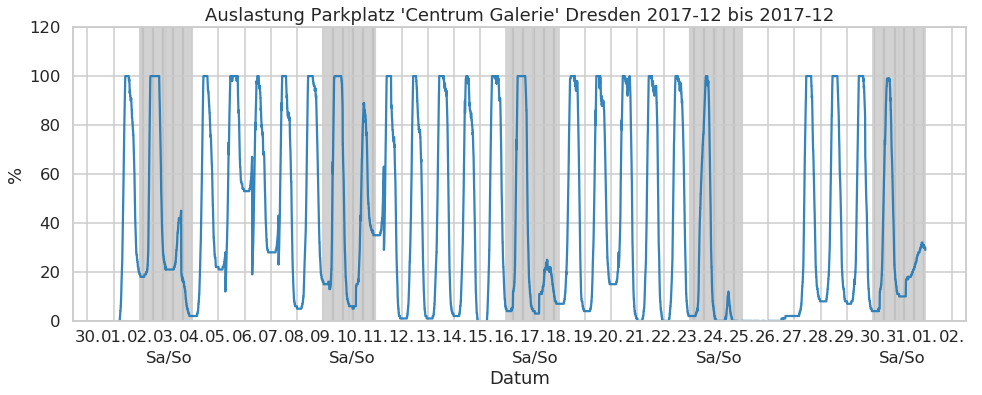

In [9]:
plotbelegung(data['Belegung'], name, '2017-12', '2017-12');

# Let's do some Machine Learning on that

## Features

* Uhrzeit
* Wochentag
* Monat
* Verkaufsoffener Sonntag?
* nächster Tag Feiertag? (Deutschland)
* übernächster Tag auch noch Feiertag? (Deutschland)
* Ferien (Deutschland)
* spezielles Event in Galerien oder Stadt oder Kultur
* nächster Tag Feiertag? (Tschechien)
* übernächster Tag auch noch Feiertag? (Tschechien)
* Ferien (Tschechien)
* Wetter

Wir haben nicht alle Features. Aber wenigstens die wichtigsten.

### Wochentag

Es ist wichtig, ob Montag oder Samstag oder Sonntag ist.

In [10]:
data['Wochentag'] = data.index.dayofweek

### Uhrzeit

Dann ist es natürlich extrem wichtig, ob es in der Nacht ist oder tagsüber.

In [11]:
data['Uhrzeit'] = data.index.hour*60.0 + data.index.minute

### Verkaufsoffener Sonntage

In [12]:
offeneSonntage = pd.to_datetime(['2016-12-04', '2017-12-10', '2018-12-09'])

In [13]:
def isoffenersonntag(serie):
    isoffen = False
    for offene in offeneSonntage:
        if serie.date() == offene.date():
            isoffen=True

    if isoffen:
        return 1
    else:
        return 0

In [14]:
sonntagsseries = pd.Series(data.index, name='offeneSonntage', index=data.index).apply(isoffenersonntag)
data['offenerSonntag'] = sonntagsseries

In [15]:
data[data.offenerSonntag==1].head(5)

,Belegung,Wochentag,Uhrzeit,offenerSonntag
Datum,,,,
2016-12-04 00:00:03,16,6,0.0,1
2016-12-04 00:05:37,16,6,5.0,1
2016-12-04 00:10:43,16,6,10.0,1
2016-12-04 00:15:28,16,6,15.0,1
2016-12-04 00:20:31,16,6,20.0,1


### Feiertage

Wenn ein Feiertag naht, dann gehen auch mehr Leute in die Stadt. Genauso nach einem Feiertag. Deshalb ist das ein Feature.

Get them from http://www.feiertage.net/frei-tage.php

In [16]:
feiertage = pd.DataFrame()
for year in range(2016, 2020):
    feiertage = feiertage.append(pd.read_csv('Sachsen%i.csv' % year, index_col=0, parse_dates=True, sep=';', dayfirst=True))

In [17]:
feiertage

,Feiertage,Bundesland
Tag,,
2016-01-01,Neujahr,Sachsen
2016-03-25,Karfreitag,Sachsen
2016-03-28,Ostermontag,Sachsen
2016-05-01,Maifeiertag,Sachsen
2016-05-05,Christi Himmelfahrt,Sachsen
2016-05-16,Pfingstmontag,Sachsen
2016-05-26,Fronleichnam,Sachsen
2016-10-03,Tag der Deutschen Einheit,Sachsen
2016-10-31,Reformationstag,Sachsen


Mit [numpy.busday_count](http://docs.scipy.org/doc/numpy/reference/generated/numpy.busday_count.html) bekommen wir die Anzahl der Werktage bis zum nächsten Feiertag, weil die Leute ja vor einem langen Wochenende immer noch mal richtig einkaufen gehen.

In [18]:
def shoppingdaystonextfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(df.date(), feiertag.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [19]:
feiertagseries = pd.Series(data.index, name='Feiertage', index=data.index).apply(shoppingdaystonextfeiertag)
data['bisFeiertag'] = feiertagseries

In [20]:
def shoppingdaysafterfeiertag(df):
    diffs = []
    for feiertag in feiertage.index:
        diff = np.busday_count(feiertag.date(), df.date(), weekmask='Mon Tue Wed Thu Fri Sat')
        #print('%s bis %s: %i Arbeitstage' % (feiertag, df, diff)) 
        diffs.append(diff)
        
    try:
        return min([d for d in diffs if d>=0])
    except:
        return 100 # wenn kein Feiertag gefunden

In [21]:
feiertagseries = pd.Series(data.index, name='Feiertage', index=data.index).apply(shoppingdaysafterfeiertag)
data['nachFeiertag'] = feiertagseries

### Schulferien

Schulferien Sachsen: http://www.schulferien.org/Sachsen/sachsen.html

In [22]:
schulferien = [['2016-02-08','2016-02-19'],
               ['2016-03-25','2016-04-01'],
               ['2016-06-27','2016-08-05'],
               ['2016-10-03','2016-10-15'],
               ['2017-02-13','2017-02-24'],
               ['2017-04-13','2017-04-22'],
               ['2017-05-25','2017-05-26'],
               ['2017-06-26','2017-08-04'],
               ['2017-10-02','2017-10-14'],
               ['2017-10-30','2017-10-31'],
               ['2017-12-23','2018-01-02'],
               ['2018-02-12','2018-02-23'],
               ['2018-03-29','2018-04-06'],
               ['2018-05-19','2018-05-22'],
               ['2018-07-02','2018-08-10'],
               ['2018-10-08','2018-10-20'],
               ['2018-12-22','2019-01-04']]

In [23]:
def isschulferien(series):
    now = series.date()
    
    inferien = False
    for ferien in schulferien:
        anfang = pd.to_datetime(ferien[0]).date()
        ende = pd.to_datetime(ferien[1]).date()

        if now >= anfang and now <= ende:
            inferien = True

    if inferien:
        return 1
    else:
        return 0

In [24]:
ferienseries = pd.Series(data.index, name='Schulferien', index=data.index).apply(isschulferien)
data['Schulferien'] = ferienseries

In [25]:
# This is much faster!
data['Schulferien'] = 0
for sf in schulferien:
    data.loc[sf[0]:sf[1]] = 1

### Weihnachten

In [26]:
def isweihnachten(series):
    if series.month==12:
        return 1
    else:
        return 0

In [27]:
weihnachtsseries = pd.Series(data.index, name='Weihnachten', index=data.index).apply(isweihnachten)
data['Weihnachten'] = weihnachtsseries

### Check

In [28]:
data.groupby([data.index.year, data.index.month, data.index.day]).first()

Belegung  Wochentag  Uhrzeit  offenerSonntag  bisFeiertag  \
Datum Datum Datum                                                              
2016  1     1            32          4      0.0               0            0   
            2            17          5      0.0               0           71   
            3            11          6      0.0               0           70   
            4            11          0      0.0               0           70   
            5           100          1      0.0               0           69   
            6            -2          2      0.0               0           68   
            7             6          3      0.0               0           67   
            8            10          4      0.0               0           66   
            9             1          5      0.0               0           65   
            10            7          6      0.0               0           64   
            11            2          0      0.0               0           64   
            12           -2          1      0.0               0           63   
            13          -10          2      0.0               0           62   
            14           -1          3      0.0               0           61   
            15            0          4      0.0               0           60   
            16            5          5      0.0               0           59   
            17           12          6      0.0               0           58   
            18            4          0      0.0               0           58   
            19            0          1      0.0               0           57   
            20            6          2      0.0               0           56   
            21            6          3      0.0               0           55   
            22            6          4      0.0               0           54   
            23           -2          5      0.0               0           53   
            24           47          6      0.0               0           52   
            25           41          0      0.0               0           52   
            26           -3          1      0.0               0           51   
            27            6          2      0.0               0           50   
            28            6          3      0.0               0           49   
            29            7          4      0.0               0           48   
            30            2          5      0.0               0           47   
...                     ...        ...      ...             ...          ...   
2018  11    27           31          1      0.0               0           24   
            28           13          2      0.0               0           23   
            29           35          3      0.0               0           22   
            30           27          4      0.0               0           21   
      12    1            10          5      2.0               0           20   
            2            14          6      0.0               0           19   
            3            12          0      0.0               0           19   
            4            26          1      0.0               0           18   
            10          100          0    710.0               0           13   
            11           24          1      0.0               0           12   
            12           16          2      0.0               0           11   
            13            0          3      0.0               0           10   
            14            3          4      0.0               0            9   
            15            3          5      0.0               0            8   
            16            1          6      0.0               0            7   
            17            8          0      0.0               0            7   
            18            4          1      0.0               0            6   
            19     

### Featurevector

In [29]:
featurevector = ['Wochentag','Uhrzeit','Schulferien','offenerSonntag','bisFeiertag','nachFeiertag','Weihnachten']

OK, nun haben wir Labels und Features fertig.

Nun können wir Test und Trainingsdatensatz erstellen.

## Train some Machine Learning Classifiers

In [30]:
labels = data['Belegung'].values
np.shape(labels)

(302533,)

In [31]:
features = data[featurevector].values
np.shape(features)

(302533, 7)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score

In [33]:
from sklearn.tree import DecisionTreeRegressor

### Split into test and training set

To get an accuracy score, we need to split our dataset in a training and a test set. We train with the training set and test the model later with the part of the test set.

In [34]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.2, random_state=0)

In [35]:
np.shape(labels_test)

(60507,)

### DecisionTreeRegressor

Because it is a regression (output of the prediction are integer) it might fit the data better than a classifier. So we test the the predicted labels with the test labels with the $R^2$ score (coefficient of determination).

In [36]:
print('max_depth\tmin_samples_leaf\tR2_score (higher is better)')
maxscore = 0.8
for md in range(5, 25):
    for mins in range(10, 30):
        classifier = DecisionTreeRegressor(max_depth=md, min_samples_leaf=mins).fit(features_train, labels_train)
        labels_predict = classifier.predict(features_test)
        #labels_rounded = [round(label/10.0)*10.0 for label in labels_predict]
        score = r2_score(labels_test, labels_predict)
        if score>maxscore:
            print('%i\t\t\t%i\t\t\t%.3f' % (md, mins, score))
            maxscore=score

max_depth	min_samples_leaf	R2_score (higher is better)
9			10			0.805
10			10			0.826
11			10			0.849
12			10			0.875
13			10			0.893
14			10			0.911
15			10			0.923
16			10			0.933
17			10			0.940
18			10			0.945
19			10			0.949
20			10			0.953
21			10			0.956
22			10			0.957
23			10			0.959
24			10			0.960


A high $R^2$-score is better, but if we have a high `max_depth` and low `min_samples_leaf`, we might overfit the dataset. The score is not everything. See [Tips on Practical Use of Decision Trees](http://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use)

## Model

In [37]:
classifier = DecisionTreeRegressor(max_depth=10, min_samples_leaf=20)
classifier.fit(features_train, labels_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

### Overfit test

One can check for overfitting by just test the model with the training features. If the score is very high (and the score with the test features is low), it is likely, that the model is overfitted.

In [38]:
# Let's check if we overfit. If, the accuracy with the training set is very high, with the test set very low.
labels_predict_overfittest = classifier.predict(features_train).astype('int')
score = accuracy_score(labels_train, labels_predict_overfittest)
print('%.3f Accuracy Score with training data' % (score))

if score>0.4:
    print('You probably overfit it!')

0.275 Accuracy Score with training data


### What is the most important feature for the model

In [39]:
importances = classifier.feature_importances_

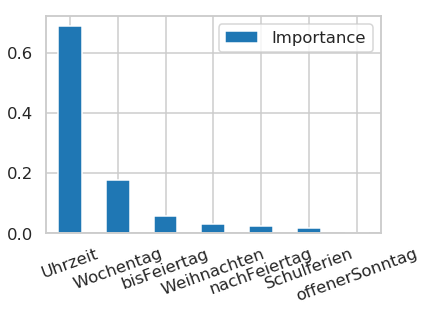

In [40]:
featureimportance = pd.DataFrame(index=featurevector, data=importances, columns=['Importance']).sort_values('Importance', ascending=False).plot(kind='bar', rot=20)

Obviously it is the time of the day (`Minuten` since midnight), the calender week, the days until the next holiday (because people tend to go shopping if the weekend is long) and for sure the day of the week (because saturday is shopping day!).

In [41]:
labels_predict = classifier.predict(features_test).astype('int')

In [42]:
r2_score(labels_test, labels_predict)

0.8244434129079825

### Let's take a look at the confusion matrix

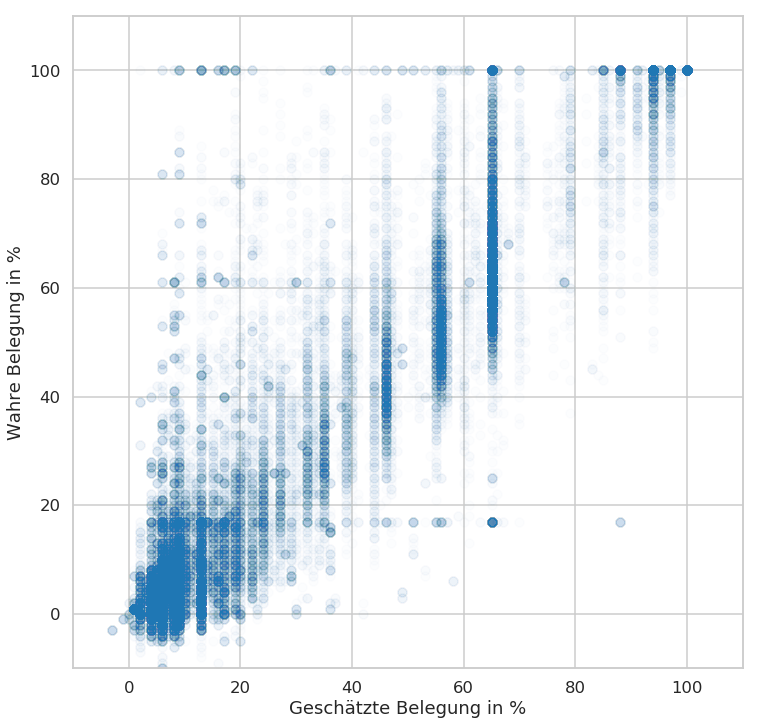

In [43]:
plt.figure(figsize=(12,12))
plt.scatter(labels_predict, labels_test, alpha=0.01)
plt.ylabel(u'Wahre Belegung in %')
plt.xlabel(u'Geschätzte Belegung in %')
plt.xlim([-10, 110])
plt.ylim([-10, 110]);

As you can see, the confusion matrix looks pretty good. That's not perfect, but take into account, that we just have a few features for such a complex scenario like inner-city parking space occupation.

# Predict

Here we predict it for the whole dataset

In [44]:
def predictBelegung(df):
    features = df[featurevector].values
    prediction = int(classifier.predict([features]))
    return prediction

Fire it on the whole Dataset

In [45]:
data['Vorhersage'] = data.apply(predictBelegung, axis=1)

In [47]:
data['Vorhersage'] = data['Vorhersage'].rolling(window=8).mean().shift(-4)

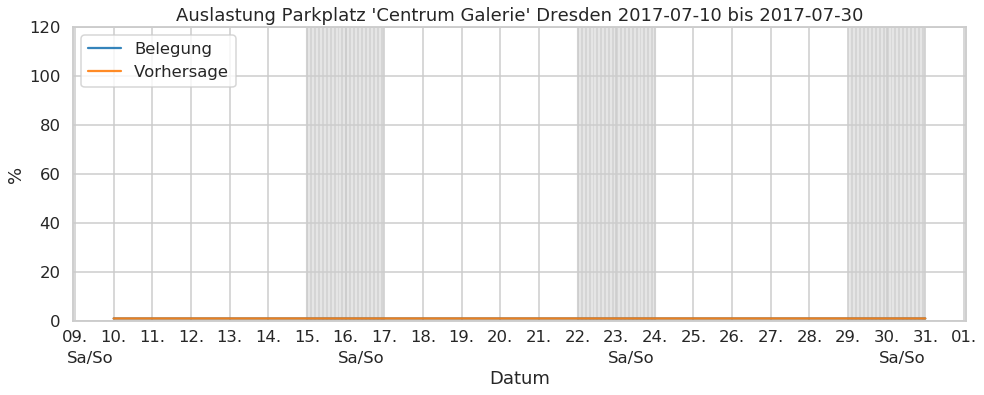

In [48]:
plotbelegung(data[['Belegung', 'Vorhersage']], name, '2017-07-10', '2017-07-30');

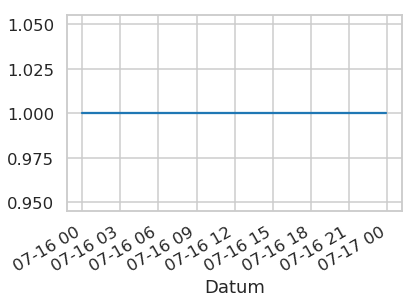

In [61]:
data['Vorhersage']['2018-07-16'].plot()

# If we want to predict the future, let's create it

In [50]:
future = pd.DataFrame(index=pd.date_range('2018-12-30', '2020-01-01', freq='15Min'))
future.index.name = 'date'
future['Wochentag'] = future.index.dayofweek
#future['KW'] = future.index.week
future['Uhrzeit'] = future.index.hour*60.0 + future.index.minute
ferienseries = pd.Series(future.index, name='Schulferien', index=future.index).apply(isschulferien)
future['Schulferien'] = ferienseries
feiertagseries = pd.Series(future.index, name='Feiertage', index=future.index).apply(shoppingdaystonextfeiertag)
future['bisFeiertag'] = feiertagseries
feiertagseries = pd.Series(future.index, name='Feiertage', index=future.index).apply(shoppingdaysafterfeiertag)
future['nachFeiertag'] = feiertagseries
sonntagsseries = pd.Series(future.index, name='offeneSonntage', index=future.index).apply(isoffenersonntag)
future['offenerSonntag'] = sonntagsseries
weihnachtsseries = pd.Series(future.index, name='Weihnachten', index=future.index).apply(isweihnachten)
future['Weihnachten'] = weihnachtsseries

### And predict the occupancy of the parking-space `Centrum-Galerie` with the future features

In [51]:
future['Vorhersage'] = future.apply(predictBelegung, axis=1)

In [52]:
future['Vorhersage'] = future['Vorhersage'].rolling(window=8).mean().shift(-4)

In [53]:
future.head()

,Wochentag,Uhrzeit,Schulferien,bisFeiertag,nachFeiertag,offenerSonntag,Weihnachten,Vorhersage
date,,,,,,,,
2018-12-30 00:00:00,6,0.0,1,1,4,0,1,NaN
2018-12-30 00:15:00,6,15.0,1,1,4,0,1,NaN
2018-12-30 00:30:00,6,30.0,1,1,4,0,1,NaN
2018-12-30 00:45:00,6,45.0,1,1,4,0,1,1.0
2018-12-30 01:00:00,6,60.0,1,1,4,0,1,1.0


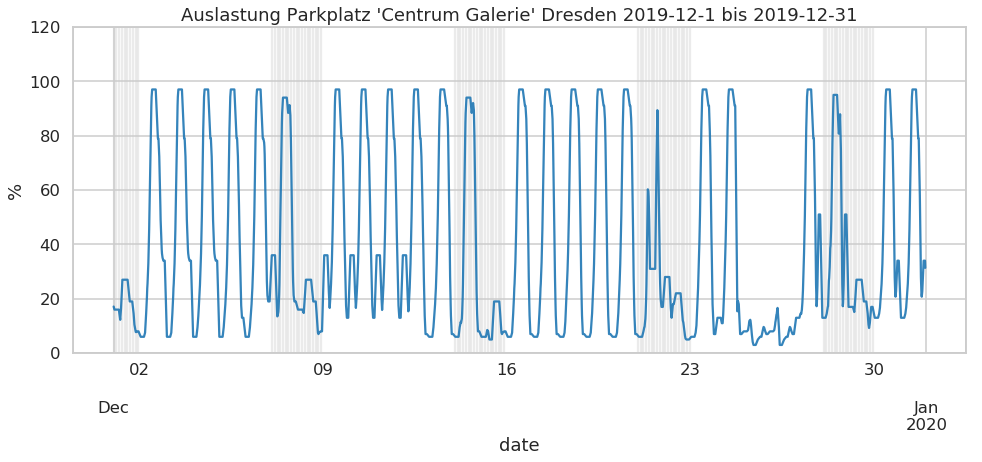

In [63]:
plotbelegung(future['Vorhersage'], name, '2019-12-1', '2019-12-31')
plt.savefig('%s-Belegung-Vorhersage-2019.png' % name, bbox_inches='tight', dpi=150)

### Save as .csv

In [55]:
future.dropna(inplace=True)
future['Vorhersage'].to_csv('%s-Belegung-Vorhersage-2019-15min.csv' % name,
                            header=False,
                            float_format='%i',
                            date_format ='%Y-%m-%dT%H:%M:%S')

## Save the Classifier for later use

Later you can load back the pickled model (possibly in another Python process) with:

`with open('classifier.pkl', 'rb') as fid:
    classifier = pickle.load(fid)`

In [56]:
import pickle
with open('./Classifier/DecisionTreeRegressor-%s.pkl' % name, 'wb') as fid:
    pickle.dump(classifier, fid)  

Questions: [@Balzer82](https://twitter.com/Balzer82)